# PROJECT -  A2Z CUSTOMER SEGMENTATION

## Introduction
Data herein presented pertains to a fictional insurance company in Portugal, A2Z Insurance. The goal is to develop a customer segmentation strategy that will enable the Marketing Department to better understand the different customers' profiles and develop adequate marketing strategies. <br>
This project is done within the cope of the **Data Mining** curricular unit of the Master's Degree in **Data Science and Advanced Analytics**.

#### Group elements:
* Ivan Jure Parać (20210689)
* Nuno de Bourbon e Carvalho Melo (20210681)
* Stuart Gallina Ottersen (20210703)


## Table of Contents
1. [Data exploration](#data-exploration)
2. [Data preprocessing](#data-preprocessing)
    1. [First steps](#preprocessing-first-steps)
    2. [Dealing with outliers](#preprocessing-outliers)
    3. [Handling missing values](#preprocessing-missing-values)
    4. [Feature creation and cross field validation](#preprocessing-transform-validate)
    5. [Feature selection](#preprocessing-feature-selection)
    6. [Feature skewness](#preprocessing-scaling)
3. [Clustering](#data-clustering)
    1. [Sociodemographic clustering](#clustering-sociodemographic)
    2. [Value clustering](#clustering-value)
    3. [Product clustering](#clustering-product)

***

<h2><center>BOILERPLATE</center></h2>

***

In [1]:
# uncomment next line of code to install package required for KPrototypes
# !pip install kmodes

In [2]:
# import major libraries/modules
import pyreadstat
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn.metrics as metrics

# others
from math import ceil
from regressors import stats
from scipy.cluster import hierarchy
from scipy.stats import chi2_contingency
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoCV
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation, OPTICS, MeanShift
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

#from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
#from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# load SAS file with the insurance company data
df, meta = pyreadstat.read_sas7bdat('a2z_insurance.sas7bdat')

# save copy of the original dataframe
original_df = df.copy()

<a class="anchor" id="data-exploration"></a>

***

<h2><center>DATA EXPLORATION</center></h2>

***

In [5]:
# first look at the dataframe
df.head()

,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1.0,1985.0,1982.0,2 - High School,2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2.0,1981.0,1995.0,2 - High School,677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3.0,1991.0,1970.0,1 - Basic,2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4.0,1990.0,1981.0,3 - BSc/MSc,1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5.0,1986.0,1973.0,3 - BSc/MSc,1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [6]:
# check number of rows and columns
print("Number of observations:", df.shape[0])
print("Number of features:", df.shape[1])
print("Features:", list(df.columns))

Number of observations: 10296
Number of features: 14
Features: ['CustID', 'FirstPolYear', 'BirthYear', 'EducDeg', 'MonthSal', 'GeoLivArea', 'Children', 'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork']


In [7]:
# describe the data
df.describe(include = "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustID,10296.0,NaN,NaN,NaN,5148.5,2972.34352,1.0,2574.75,5148.5,7722.25,10296.0
FirstPolYear,10266.0,NaN,NaN,NaN,1991.062634,511.267913,1974.0,1980.0,1986.0,1992.0,53784.0
BirthYear,10279.0,NaN,NaN,NaN,1968.007783,19.709476,1028.0,1953.0,1968.0,1983.0,2001.0
EducDeg,10296,5,3 - BSc/MSc,4799,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthSal,10260.0,NaN,NaN,NaN,2506.667057,1157.449634,333.0,1706.0,2501.5,3290.25,55215.0
GeoLivArea,10295.0,NaN,NaN,NaN,2.709859,1.266291,1.0,1.0,3.0,4.0,4.0
Children,10275.0,NaN,NaN,NaN,0.706764,0.455268,0.0,0.0,1.0,1.0,1.0
CustMonVal,10296.0,NaN,NaN,NaN,177.892605,1945.811505,-165680.42,-9.44,186.87,399.7775,11875.89
ClaimsRate,10296.0,NaN,NaN,NaN,0.742772,2.916964,0.0,0.39,0.72,0.98,256.2
PremMotor,10262.0,NaN,NaN,NaN,300.470252,211.914997,-4.11,190.59,298.61,408.3,11604.42


In [8]:
# more information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustID         10296 non-null  float64
 1   FirstPolYear   10266 non-null  float64
 2   BirthYear      10279 non-null  float64
 3   EducDeg        10296 non-null  object 
 4   MonthSal       10260 non-null  float64
 5   GeoLivArea     10295 non-null  float64
 6   Children       10275 non-null  float64
 7   CustMonVal     10296 non-null  float64
 8   ClaimsRate     10296 non-null  float64
 9   PremMotor      10262 non-null  float64
 10  PremHousehold  10296 non-null  float64
 11  PremHealth     10253 non-null  float64
 12  PremLife       10192 non-null  float64
 13  PremWork       10210 non-null  float64
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


<a class="anchor" id="data-preprocessing"></a>

***

<h2><center>DATA PREPROCESSING</center></h2>

***

In [9]:
def plot_multiple(df, features, plot_type, fig_dimensions = [15, 8], nr_rows = 1):

    '''
    Takes in a dataframe, df, a list of features, features,
    a plot type, plot_type, the dimensions of the figure,
    fig_dimensions, and the number of rows of the figure,
    nr_rows, as argument, and plots the specified plot type
    for the features passed as arguments.

    Arguments:
     df (dataframe): dataframe
     features (list): features from df to plot (min. 2 features)
     plot_type (str): type of plot (box, violin, or histogram)
     fig_dimensions (list, tuple): figure dimensions
     nr_rows (int): number of rows in the figure

    Returns:
     None
    '''

    sns.set(style = "ticks")

    fig, axes = plt.subplots(nr_rows, ceil(len(features) / nr_rows), figsize = fig_dimensions)
    
    # iterate through axes and associate each plot to one
    for ax, feat in zip(axes.flatten(), features):
        if (plot_type.lower() == "box") or (plot_type.lower() == "boxplot"):
            sns.boxplot(
                data = df,
                x = feat,
                color = "C9",
                ax = ax
            )

        if (plot_type.lower() == "violin" or (plot_type.lower() == "violinplot")):
            sns.violinplot(
                data = df,
                x = feat,
                color = "C9",
                ax = ax
            )

        if (plot_type.lower() == "histogram" or (plot_type.lower() == "histplot")):
            sns.histplot(
                data = df,
                x = feat,
                color = "C9",
                ax = ax
            )

    plt.show()

    return

<a class="anchor" id="preprocessing-first-steps"></a>

<h3><right>First steps</right></h3>

* Set customer ID as index
* Remove duplicated observations
* Encode EducDeg and change to float
* Swap incoherent birth and first policy years

In [10]:
# set customer ID as index
df.CustID = df.CustID.astype("int")
df.set_index("CustID", inplace = True)

In [11]:
# check for duplicated rows
print("Number of duplicates:", df.duplicated().sum())

# remove duplicate rows
df.drop_duplicates(inplace = True)
print("Removing duplicates...")
print("Number of duplicates:", df.duplicated().sum())

# store initial number of rows (after duplicate removal)
initial_len = len(df)

# check number of rows and columns again
print("\nCurrent number of observations:", df.shape[0])
print("Current number of features:", df.shape[1])

df.head()

Number of duplicates: 3
Removing duplicates...
Number of duplicates: 0

Current number of observations: 10293
Current number of features: 13


,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
1,1985.0,1982.0,2 - High School,2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
2,1981.0,1995.0,2 - High School,677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
3,1991.0,1970.0,1 - Basic,2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
4,1990.0,1981.0,3 - BSc/MSc,1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
5,1986.0,1973.0,3 - BSc/MSc,1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [12]:
# checking data types

# extract number from EducDeg, save as float
df.EducDeg = df.EducDeg.str.extract("(\d+)").astype("float")
# education degree mapper (to replace numbers when needed)
educ_mapper = {1: "Basic", 2: "High School", 3: "BSc/MSc", 4: "PhD"}

# check data types
df.dtypes

FirstPolYear     float64
BirthYear        float64
EducDeg          float64
MonthSal         float64
GeoLivArea       float64
Children         float64
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

In [13]:
# swaps years if policy seems to be made before birth
nr_incoherences = len(df[df.BirthYear > df.FirstPolYear])
pc_incoherences = round(nr_incoherences/len(df)*100, 1)

print(f"Number of people with a policy before birth: {nr_incoherences} "
    f"({pc_incoherences}% of the dataset)")

# such high number of inconsistencies suggests systematic error
# assumption: in these cases BirthYear and FirstPolYear were introduced in the wrong fields
print("Swapping birth and first policy years...")

# swap FirstPolYear and BirthYear values when birth occurs after first policy creation
row_filter = df.BirthYear > df.FirstPolYear
df.loc[row_filter, ["FirstPolYear", "BirthYear"]] = df.loc[row_filter, ["BirthYear", "FirstPolYear"]].values

# check if the years were correctly swapped
nr_incoherences = len(df[df.BirthYear > df.FirstPolYear])
print(f"Number of people with a policy before birth: {nr_incoherences}")

Number of people with a policy before birth: 1997 (19.4% of the dataset)
Swapping birth and first policy years...
Number of people with a policy before birth: 0


<a class="anchor" id="preprocessing-outliers"></a>

<h3><right>Dealing with outliers</right></h3>

* Remove outliers and store them in a separate dataframe

In [14]:
def remove_outliers(df, filters):

    # create a separate dataframe for the outliers
    outliers = pd.DataFrame()

    # remove outliers from main dataframe
    # add outliers to a separate dataframe
    for filter_ in filters:
        outliers = outliers.append(df[filter_])
        df = df[~filter_]
        
    # determine number of outliers removed
    n_outliers = len(outliers)
    pc_removed = round(n_outliers/initial_len*100, 2)
    print(f"Number of outliers removed: {n_outliers} ({pc_removed}% of all observations)")

    return (df, outliers)

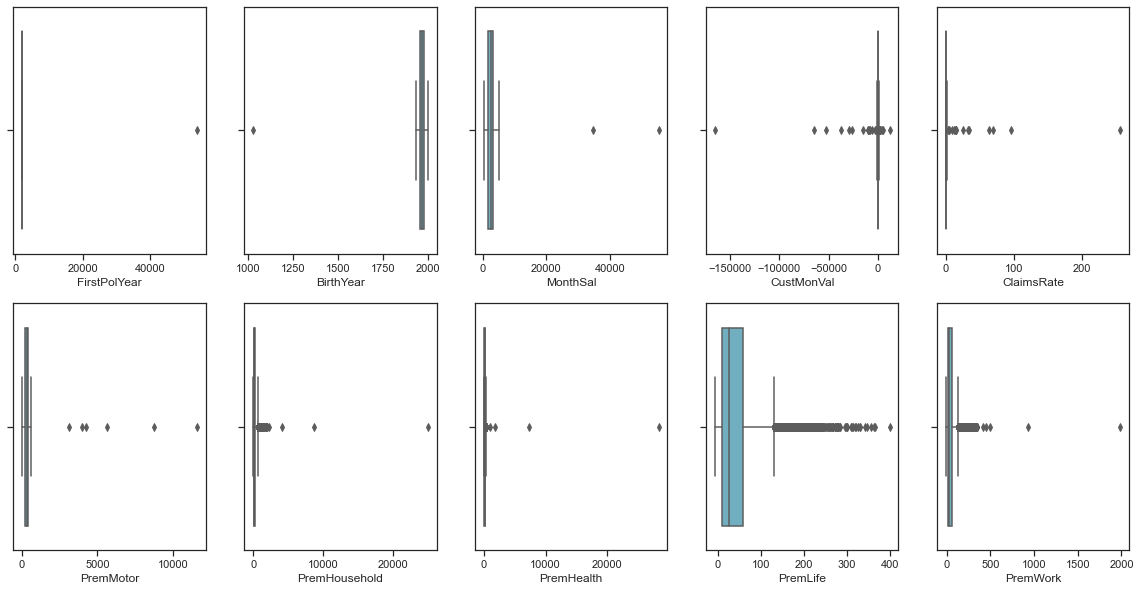

In [15]:
# define metric and non-metric features
metric_features = df.columns.drop(["EducDeg", "GeoLivArea", "Children"])
non_metric_features = ["EducDeg", "GeoLivArea", "Children"]

# boxplots of metric features
plot_multiple(df, metric_features, "box", [20, 10], nr_rows = 2)

Number of outliers removed: 134 (1.3% of all observations)


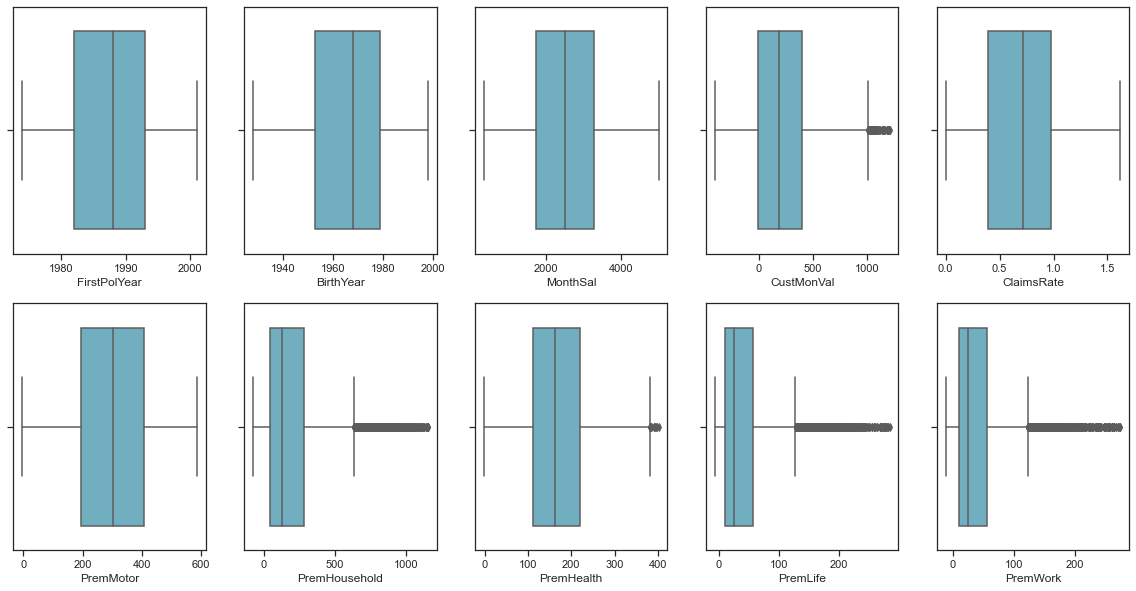

In [16]:
# BirthYear 1028 assumed to be a typo
# 0 and 9 are fairly close in a qwerty keyboard, replaced with 1928
df.loc[df.BirthYear == 1028, "BirthYear"] = 1928

# remove outliers from df, store them in df_outliers1
filters = (
    (df.FirstPolYear.ge(2017)),
    (df.MonthSal.ge(20000)),
    (df.CustMonVal.le(-2000)),
    (df.CustMonVal.ge(1250)),
    (df.ClaimsRate.ge(4)),
    (df.PremMotor.ge(3000)),
    (df.PremHousehold.ge(1160)),
    (df.PremHealth.ge(405)),
    (df.PremLife.ge(290)),
    (df.PremWork.ge(275))
)

df, df_outliers1 = remove_outliers(df, filters)

# boxplots of metric features after removing outliers
plot_multiple(df, metric_features, "box", [20, 10], nr_rows = 2)

<a class="anchor" id="preprocessing-missing-values"></a>

<h3><right>Handling missing values</right></h3>

* Check feature and row completeness (in df and df_outliers)
* Remove customers with no information about Premiums
* Remove customers with missing FirstPolYear or BirthYear
* Remove customers with missing EducDeg
* Fill Premium missing values with zero
* Create Linear Regression model to impute MonthSal
* Create Logistic Regression model to impute Children

In [17]:
def check_completeness(df):

    '''
    Takes in a dataframe, df, as argument and
    computes the number/percentage of missing
    values per feature, and the number of rows
    with the maximum number of missing values.

    Arguments:
     df (dataframe): dataframe

    Returns:
     None
    '''

    # number and percentage of NaN values per feature
    nr_nans = df.isna().sum()
    pc_nans = df.isna().mean()*100
    feature_nans = pd.concat([nr_nans, pc_nans], axis = 1)
    feature_nans.rename(columns = {0: "nr", 1: "%"}, inplace = True)

    # show number of missing values per feature
    print("Missing values per feature:\n", feature_nans)

    # check row completeness
    # max number of NaN values in a row and number of rows with that many NaN
    max_row_nan = df.isnull().sum(axis = 1).max()
    
    print(f"\nMaximum number of NaN values per row: {max_row_nan} "
        f"({len(df[df.isnull().sum(axis = 1) == max_row_nan])} rows)")

    return

In [18]:
def remove_missing_values(df, cols, max_nan_per_row):

    '''
    Takes in a dataframe, df, a list of columns, cols,
    and the maximum number of nan per row, max_nan_per_row,
    and removes rows that have missing values in the columns
    passed on as arguments as well as rows that exceed the
    maximum number of missing values allowed.

    Arguments:
     df (dataframe): dataframe
     cols (list): column(s) in df to remove NaN
     max_nan_per_row (int): max number of NaN allowed per row

    Returns:
     df (dataframe): dataframe after removing NaN
     df_nan (dataframe): dataframe with the NaN rows removed from df
    '''

    # create dataframe to store rows discarded due to missing values
    df_nan = pd.DataFrame()

    # removing rows above the threshold of maximum missing values allowed
    max_nan_rows = df[df.isnull().sum(axis = 1) >= max_nan_per_row]
    df_nan = df_nan.append(max_nan_rows)
    df.drop(max_nan_rows.index, inplace = True)

    print(
        f"Removed {len(max_nan_rows)} row(s) "
        f"missing ({round(max_nan_per_row/len(df.columns)*100, 1)}% of data)"
    )

    # remove rows with missing values from features passed as arguments
    # add these rows to df_nan
    for col in cols:
        nan_ = df[col].isna()
        nr_removed = sum(nan_)

        df_nan = df_nan.append(df[nan_])
        df = df[~nan_]

        print(f"Removed {nr_removed} row(s) (NaN in {col})")

    # show total number of missing values removed
    nr_rows_removed = len(df_nan)
    total_removed = initial_len - len(df)

    print(
        f"Total number of rows removed: {nr_rows_removed}\n"
        f"Total number of rows removed so far: {total_removed} "
        f"({round(total_removed/initial_len*100, 2)}%)"
    )

    return (df, df_nan)

In [19]:
def zero_imputer(df, cols):

    '''
    Takes in a dataframe, df, and a list of columns,
    cols, and replaces existing missing values in
    those columns with zero.

    Arguments:
     df (dataframe): dataframe
     cols (list): column(s) in df to impute NaN with 0
    
    Returns:
     df (dataframe): dataframe after value imputation
    '''

    # save the total number of imputed values
    total_imputations = 0

    # impute each NaN value in cols with zero
    for col in cols:
        col_nan = sum(df[col].isna())
        df[col].fillna(0, inplace = True)

        # print number of imputed values per column
        print(f"Imputed {col_nan} out of {col_nan} missing value(s) in {col}")
        
        total_imputations += col_nan

    print(f"Total number of imputations: {total_imputations}")

    return df

In [20]:
def linreg_imputer(df, regressors, regressand):

    '''
    Takes in a dataframe, df, a list of regressor names,
    regressors, and the name of the regressand, regressand,
    and uses a linear regression model to predict missing
    values in the regressand based on the regressors.

    Arguments:
     df (dataframe): dataframe
     regressors (str, list): list of columns in df to be used
    in linear regression to predict the regressand
     regressand (str): name of column in df whose missing values
    will be imputed with values predicted by linear regression

    Returns:
     df (dataframe): dataframe after value imputation
    '''

    # independent, X, and dependent, y, variables
    X = df.dropna()[regressors]
    y = df.dropna()[regressand]

    # split train and validation data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 15)

    # reshaping needed if a string and not a list is passed as argument for regressors
    if (type(regressors) is not list) and (type(regressors) is str):
        X_train = np.array(X_train).reshape(-1, 1)
        X_val = np.array(X_val).reshape(-1, 1)

    # scale features using MinMaxScaler() with parameters from X_train
    scaler = MinMaxScaler().fit(X_train)
    # scale the training and test sets
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # create and fit model
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_scaled, y_train)

    # predict salary of the validation set
    y_pred = lin_reg.predict(X_val_scaled)

    # compute metrics for the predictions made
    mse = metrics.mean_squared_error(y_val, y_pred)
    rmse = metrics.mean_squared_error(y_val, y_pred, squared = False)
    mae = metrics.mean_absolute_error(y_val, y_pred)

    print("")
    print("======================================================")
    print("                Linear regression model               ")
    print("======================================================")
    print("Mean square error:", round(mse, 2))
    print("Root mean square error:", round(rmse, 2))
    print("Mean absolute error:", round(mae, 2))
    stats.summary(clf = lin_reg, X = X_train_scaled, y = y_train)
    print("======================================================")

    # predict missing values in the regressand column
    X_test = df.loc[df[regressand].isna(), regressors]

    # reshaping needed if a string and not a list is passed as argument for regressors
    if type(regressors) is not list:
        X_test = np.array(X_test).reshape(-1, 1)

    X_test_scaled = scaler.transform(X_test)
    y_pred = lin_reg.predict(X_test_scaled)

    # impute missing values in the regressand column
    df.loc[df[regressand].isna(), regressand] = y_pred
    
    print(f"\nImputed {len(y_pred)} values in {regressand}")

    #df.loc[df.MonthSal.isna(), "MonthSal"] = y_pred

    # multiple linear regression model to impute missing MonthSal values
    # use all features but the MonthSal to train the model

    # define independent and dependent variables
    #X = df.dropna().drop(["MonthSal"], axis = 1)
    #y = df.dropna().MonthSal

    # split train and test data
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

    # scale train and test data
    #scaler = MinMaxScaler().fit(X_train)
    #X_train_scaled = scaler.transform(X_train)
    #X_test_scaled = scaler.transform(X_test)

    # create and fit model
    #lin_model = LinearRegression()
    #lin_model.fit(X_train_scaled, y_train)

    # predict y
    #y_pred = lin_model.predict(X_test_scaled)

    # evaluate the predictions of the linear reg model
    #xlabels = X_train.columns
    #stats.summary(clf = lin_model, X = X_train_scaled, y = y_train, xlabels = xlabels)
    #mse = metrics.mean_squared_error(y_test, y_pred)
    #rmse = metrics.mean_squared_error(y_test, y_pred, squared = False)
    #mae = metrics.mean_absolute_error(y_test, y_pred)

    #print(mse)
    #print(rmse)
    #print(mae)

    return df

In [21]:
def logreg_imputer(df, regressors, regressand):
            
    # imputing missing Children values
    # conclusion based on previous feature selection: use only BirthYear

    # independent, X, and dependent, y, variables
    X = df.dropna()[regressors]
    y = df.dropna()[regressand]

    # split data into train (70%) and validation (30%) datasets
    # 70% have children, 30% dont, decided to stratify
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 5, stratify = y)

    # reshaping needed if a string and not a list is passed as argument for regressors
    if type(regressors) is not list:
        X_train = np.array(X_train).reshape(-1, 1)
        X_val = np.array(X_val).reshape(-1, 1)

    # scale features using MinMaxScaler with parameters from X_train
    scaler = MinMaxScaler().fit(X_train)
    # scale the training and test sets
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # create a logistic regression model
    log_reg = LogisticRegression()
    log_reg.fit(X_train_scaled, y_train)

    # predict y
    y_pred = log_reg.predict(X_val_scaled)

    # evaluate the predictions of the logistic reg model
    conf_matrix = metrics.confusion_matrix(y_val, y_pred)
    conf_matrix = pd.DataFrame(conf_matrix)
    accuracy = round(metrics.accuracy_score(y_val, y_pred)*100, 2)
    precision = round(metrics.precision_score(y_val, y_pred)*100, 2)
    recall = round(metrics.recall_score(y_val, y_pred)*100, 2)
    f1 = round(metrics.f1_score(y_val, y_pred)*100, 2)

    print("==============================================")
    print("           Logistic regression model          ")
    print("==============================================")
    print("Accuracy:", accuracy, "%")
    print("Precision:", precision, "%")
    print("Recall:", recall, "%")
    print("F1 score:", f1, "%")
    print("Confusion matrix:\n", conf_matrix)
    print("==============================================")

    # predict missing values in the regressand column
    X_test = df.loc[df[regressand].isna(), regressors]

    # reshaping needed if a string and not a list is passed as argument for regressors
    if type(regressors) is not list:
        X_test = np.array(X_test).reshape(-1, 1)
    
    X_test_scaled = scaler.transform(X_test)
    y_pred = log_reg.predict(X_test_scaled)

    # impute missing values in the regressand column
    df.loc[df[regressand].isna(), regressand] = y_pred

    print(f"\nImputed {len(y_pred)} values in {regressand}")
    
    # attempting children prediction using KNN
    # overall results were worse than with logistic regression

    #data = df.dropna().drop(["Children", "GeoLivArea"], axis = 1)
    #target = df.dropna().Children

    #X_train, X_val, y_train, y_val = train_test_split(data, target, train_size=0.70, stratify = target, random_state=5)

    #modelKNN = KNeighborsClassifier()
    #modelKNN.fit(X = X_train, y = y_train)
    #labels_train = modelKNN.predict(X_train)
    #labels_val = modelKNN.predict(X_val)

    #conf_matrix = metrics.confusion_matrix(y_val, labels_val)
    #accuracy = round(metrics.accuracy_score(y_val, labels_val)*100, 2)
    #precision = round(metrics.precision_score(y_val, labels_val)*100, 2)
    #recall = round(metrics.recall_score(y_val, labels_val)*100, 2)
    #f1 = round(metrics.f1_score(y_val, labels_val)*100, 2)

    #print("Confusion matrix:\n", conf_matrix)
    #print("Accuracy:", accuracy, "%")
    #print("Precision:", precision, "%")
    #print("Recall:", recall, "%")
    #print("F1 score:", f1, "%") 

    return df

In [22]:
def logreg_feat_selection(df, regressand):

    # independent, X, and dependent, y, variables
    X = df.dropna().drop(columns = regressand)
    y = df.dropna()[regressand]

    # split data into train (70%) and validation (30%) datasets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 5, stratify = y)

    # scale features using MinMaxScaler with parameters from X_train
    scaler = MinMaxScaler().fit(X_train)
    # scale the training set
    X_train_scaled = scaler.transform(X_train)
    # scale the test set
    X_val_scaled = scaler.transform(X_val)

    # recursive feature elimination
    numfeats_list = np.arange(1, len(df.columns))
    scores = {}

    for n in range(len(numfeats_list)):
        log_reg = LogisticRegression()
        rfe = RFE(log_reg, numfeats_list[n])
        
        X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
        X_val_rfe = rfe.transform(X_val_scaled)
        log_reg.fit(X_train_rfe, y_train)
        
        score = log_reg.score(X_val_rfe, y_val)
        scores[n+1] = score

    # RFE selected 1 single feature
    best_num_feats = max(scores, key = scores.get)
    rfe = RFE(estimator = log_reg, n_features_to_select = best_num_feats)
    rfe.fit(X = X_train_scaled, y = y_train)
    selected_features = pd.Series(rfe.support_, index = X_train.columns, name = "RFE")

    # compute correlation between Children and other features
    correlations = pd.Series(df.corr()[regressand], name = "Correlation")

    # compute Lasso coefficients
    reg = LassoCV()
    reg.fit(X_train_scaled, y_train)
    lasso_coef = pd.Series(reg.coef_, index = X_train.columns, name = "Lasso")

    # concatenate features selected by rfe, correlations, and lasso coefficients
    selection_df = pd.concat([selected_features, correlations, lasso_coef], axis = 1).drop(regressand)

    # plot correlation and lasso coefficients
    coef_names = ["Correlation", "Lasso"]

    sns.set(font_scale = 1.4)
    sns.set_style("white")
    fig, axes = plt.subplots(1, ceil(len(coef_names)), figsize = (24, 10))

    for ax, coef in zip(axes.flatten(), coef_names):
        sns.barplot(data = selection_df,
                    x = coef,
                    y = selection_df.index,
                    hue = "RFE",
                    palette = ["darkgray", "C9"],
                    order = selection_df.sort_values(coef).index,
                    ax = ax)
        ax.axvline(x = 0, linestyle = "--", color = "darkgray", label = "_nolegend_")
        ax.set_xlabel(coef + " coefficient", fontsize = 16)
        ax.legend(title = "RFE", loc = "upper right", fontsize = 14)

    plt.show()

    return

In [23]:
# check missing values in the dataframe
check_completeness(df)

Missing values per feature:
                 nr         %
FirstPolYear    30  0.295305
BirthYear       17  0.167339
EducDeg         17  0.167339
MonthSal        36  0.354366
GeoLivArea       1  0.009843
Children        21  0.206713
CustMonVal       0  0.000000
ClaimsRate       0  0.000000
PremMotor       33  0.324835
PremHousehold    0  0.000000
PremHealth      42  0.413427
PremLife       103  1.013879
PremWork        85  0.836697

Maximum number of NaN values per row: 4 (12 rows)


In [24]:
# drop missing values in the specified features
max_nan_per_row = df.isnull().sum(axis = 1).max()
cols = ["FirstPolYear", "BirthYear", "EducDeg"]
df, df_nan = remove_missing_values(df, cols, max_nan_per_row)

Removed 12 row(s) missing (30.8% of data)
Removed 30 row(s) (NaN in FirstPolYear)
Removed 14 row(s) (NaN in BirthYear)
Removed 2 row(s) (NaN in EducDeg)
Total number of rows removed: 58
Total number of rows removed so far: 192 (1.87%)


In [25]:
# impute missing values in the Premium features
cols = [col for col in df if col.startswith("Prem")]
df = zero_imputer(df, cols)

Imputed 21 out of 21 missing value(s) in PremMotor
Imputed 0 out of 0 missing value(s) in PremHousehold
Imputed 29 out of 29 missing value(s) in PremHealth
Imputed 91 out of 91 missing value(s) in PremLife
Imputed 72 out of 72 missing value(s) in PremWork
Total number of imputations: 213


In [26]:
# select feature(s) to use for linear regression of MonthSal
corr_salary = pd.Series(df.corr().MonthSal, name = "Correlation").sort_values()
print("Correlation between salary and other features:")
print(round(corr_salary, 3))

Correlation between salary and other features:
BirthYear       -0.904
Children        -0.467
FirstPolYear    -0.290
PremLife        -0.232
PremWork        -0.232
PremHousehold   -0.218
CustMonVal      -0.052
ClaimsRate       0.002
GeoLivArea       0.008
PremHealth       0.020
EducDeg          0.166
PremMotor        0.210
MonthSal         1.000
Name: Correlation, dtype: float64


In [27]:
# impute missing MonthSal values based on linear regression
salary_regressors = "BirthYear"
regressand = "MonthSal"
df = linreg_imputer(df, salary_regressors, regressand)


                Linear regression model               
Mean square error: 178655.77
Root mean square error: 422.68
Mean absolute error: 334.11
Residuals:
       Min        1Q   Median       3Q       Max
-1501.8153 -287.4902 -16.9852 265.6322 1876.3774


Coefficients:
               Estimate  Std. Error   t value  p value
_intercept  4706.377413    9.597193  490.3910      0.0
x1         -4004.895000   20.576523 -194.6342      0.0
---
R-squared:  0.81745,    Adjusted R-squared:  0.81743
F-statistic: 31507.22 on 1 features

Imputed 33 values in MonthSal


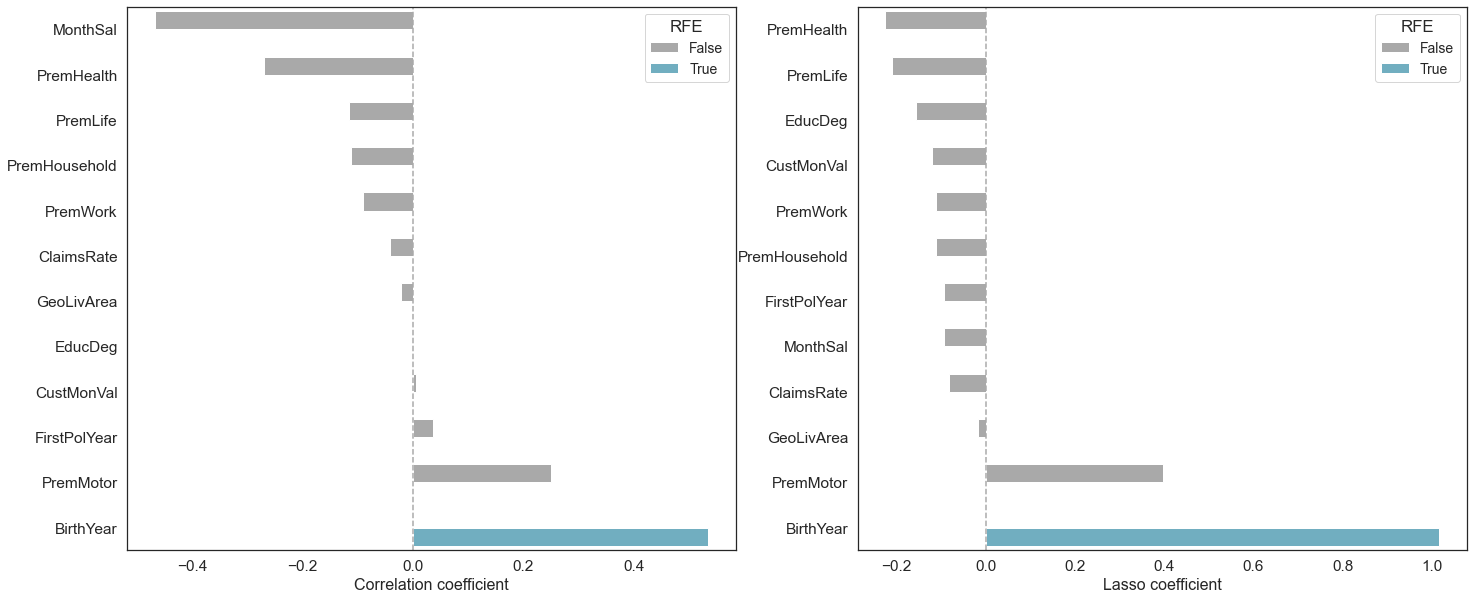

In [28]:
# choose features used for the logistic regression of Children
# compute and plot RFE results, correlations, and Lasso coefficients
logreg_feat_selection(df, "Children")

In [29]:
# impute children missing values based on selected features
children_regressors = "BirthYear"
df = logreg_imputer(df, children_regressors, "Children")

           Logistic regression model          
Accuracy: 86.29 %
Precision: 87.49 %
Recall: 94.07 %
F1 score: 90.66 %
Confusion matrix:
      0     1
0  597   288
1  127  2015

Imputed 13 values in Children


In [30]:
# check if all NaN values were dealt with
check_completeness(df)

Missing values per feature:
                nr    %
FirstPolYear    0  0.0
BirthYear       0  0.0
EducDeg         0  0.0
MonthSal        0  0.0
GeoLivArea      0  0.0
Children        0  0.0
CustMonVal      0  0.0
ClaimsRate      0  0.0
PremMotor       0  0.0
PremHousehold   0  0.0
PremHealth      0  0.0
PremLife        0  0.0
PremWork        0  0.0

Maximum number of NaN values per row: 0 (10101 rows)


In [31]:
# check missing values in df_outliers1
check_completeness(df_outliers1)

# deal with Premium missing values in df_outliers1
cols = ["PremMotor", "PremHealth", "PremLife", "PremWork"]
df_outliers1 = zero_imputer(df_outliers1, cols)

Missing values per feature:
                nr         %
FirstPolYear    0  0.000000
BirthYear       0  0.000000
EducDeg         0  0.000000
MonthSal        0  0.000000
GeoLivArea      0  0.000000
Children        0  0.000000
CustMonVal      0  0.000000
ClaimsRate      0  0.000000
PremMotor       1  0.746269
PremHousehold   0  0.000000
PremHealth      1  0.746269
PremLife        1  0.746269
PremWork        1  0.746269

Maximum number of NaN values per row: 2 (1 rows)
Imputed 1 out of 1 missing value(s) in PremMotor
Imputed 1 out of 1 missing value(s) in PremHealth
Imputed 1 out of 1 missing value(s) in PremLife
Imputed 1 out of 1 missing value(s) in PremWork
Total number of imputations: 4


<a class="anchor" id="preprocessing-transform-validate"></a>

<h3><right>Feature creation</right></h3>

* Add columns: Age, FirstPolAge, CustYears, Generation, PremTotal, Premium ratios
* Check if EducDeg makes sense given the customer's age
* Convert MonthSal to YearSal
* Remove outliers from newly created features
* Transform skewed metric features

In [32]:
def feature_creator(df):
    
    # save columns originally present in the dataframe
    initial_cols = df.columns

    # create Age column
    # (customers age as of 2016)
    curr_year = 2016
    cust_ages = curr_year - df.BirthYear
    df["Age"] = cust_ages
    
    # create FirstPolAge column
    # (customers age at the time of the first policy creation)
    firstpol_ages = df.FirstPolYear - df.BirthYear
    df["FirstPolAge"] = firstpol_ages
    
    # create CustYears column
    # (number of years as a customer to the company)
    df["CustYears"] = curr_year - df.FirstPolYear
    
    # create Generation column
    # (generation customers belongs to)
    df.loc[(df.BirthYear >= 1928) & (df.BirthYear <= 1945), "Generation"] = 1 # Silent Gen
    df.loc[(df.BirthYear >= 1946) & (df.BirthYear <= 1964), "Generation"] = 2 # Baby Boomer
    df.loc[(df.BirthYear >= 1965) & (df.BirthYear <= 1980), "Generation"] = 3 # Gen X
    df.loc[(df.BirthYear >= 1981) & (df.BirthYear <= 1996), "Generation"] = 4 # Millennial
    df.loc[(df.BirthYear >= 1997) & (df.BirthYear <= 2012), "Generation"] = 5 # Gen Z
    df.Generation = df.Generation.astype("float")
    
    # create YearSal column
    # (customers yearly income)
    year_sals = df.MonthSal * 12
    df["YearSal"] = year_sals
    
    # create a PremTotal column
    # (customers total money spent on premiums)
    premium_cols = ["PremMotor", "PremHousehold", "PremHealth", "PremLife", "PremWork"]
    df["PremTotal"] = df[premium_cols].sum(axis = 1)

    # create Effort column
    # (proportion of the yearly salary each customer spends on the company)
    efforts = df.PremTotal / df.YearSal
    df["EffortRatio"] = efforts
    
    # create PremiumRatio columns
    # (proportion of the total premium spent on each type of policy)
    for col in premium_cols:
        newcol_vals = df[col]/df["PremTotal"]
        newcol_name = col + "Ratio"
        df[newcol_name] = newcol_vals

    # verbose: list of newly created columns
    new_cols = df.columns.drop(initial_cols)
    print(f"Created {len(new_cols)} new features:\n{list(new_cols)}")
        
    return df

In [33]:
# update dataframe with new features
df = feature_creator(df)

# also add the new features to df_outliers1
# needed so that they can be assigned to clusters later on
df_outliers1 = feature_creator(df_outliers1)

# update metric and non-metric features
metric_features = df.columns.drop(["EducDeg", "GeoLivArea", "Children", "Generation"])
non_metric_features = ["EducDeg", "GeoLivArea", "Children", "Generation"]

Created 12 new features:
['Age', 'FirstPolAge', 'CustYears', 'Generation', 'YearSal', 'PremTotal', 'EffortRatio', 'PremMotorRatio', 'PremHouseholdRatio', 'PremHealthRatio', 'PremLifeRatio', 'PremWorkRatio']
Created 12 new features:
['Age', 'FirstPolAge', 'CustYears', 'Generation', 'YearSal', 'PremTotal', 'EffortRatio', 'PremMotorRatio', 'PremHouseholdRatio', 'PremHealthRatio', 'PremLifeRatio', 'PremWorkRatio']


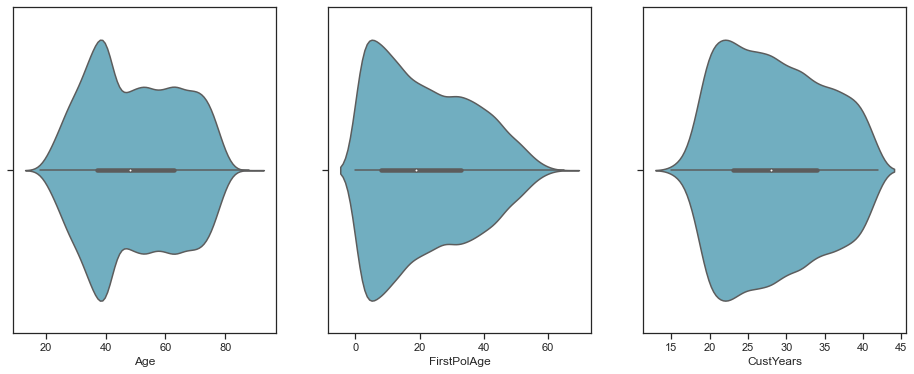

In [34]:
# violinplots of the newly created year-related features
features = ["Age", "FirstPolAge", "CustYears"]
plot_multiple(df, features, "violin", fig_dimensions = [16, 6])

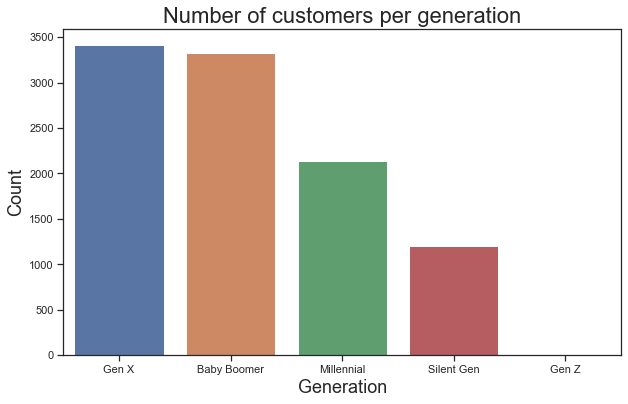

In [35]:
# visualize Generation feature
# generation mapper
gen_mapper = {
    1: "Silent Gen",
    2: "Baby Boomer",
    3: "Gen X",
    4: "Millennial",
    5: "Gen Z"
}

# count number of customers per generation
gen_count = df.groupby("Generation").size().sort_values(ascending = False)
gen_count.rename(index = gen_mapper, inplace = True)

# visualize number of customers per generation
fig, ax = plt.subplots(figsize = (10, 6))
sns.barplot(x = gen_count.index, y = gen_count.values, order = gen_count.index)
plt.title("Number of customers per generation", fontsize = 22)
plt.xlabel("Generation", fontsize = 18)
plt.ylabel("Count", fontsize = 18)

plt.show()

# almost no customers from the younger generation, Gen Z

In [36]:
# cross-validate EducDeg and Age
# minimum age is 18 - meaning everyone can have an education up to High School
# minimum age of 20 for a BSc
# minimum age of 23 for a PhD (skipping MSc and finishing in 3 years, UK or outside of the EU)
educdeg_min_age = df.groupby("EducDeg").Age.min().rename(index = educ_mapper)
print("======================================")
print("   Cross-validating EducDeg and Age   ")
print("======================================")
print("Minimum age associated to each EducDeg")
print(educdeg_min_age)

# no incoherences found

   Cross-validating EducDeg and Age   
Minimum age associated to each EducDeg
EducDeg
Basic          18.0
High School    19.0
BSc/MSc        20.0
PhD            23.0
Name: Age, dtype: float64


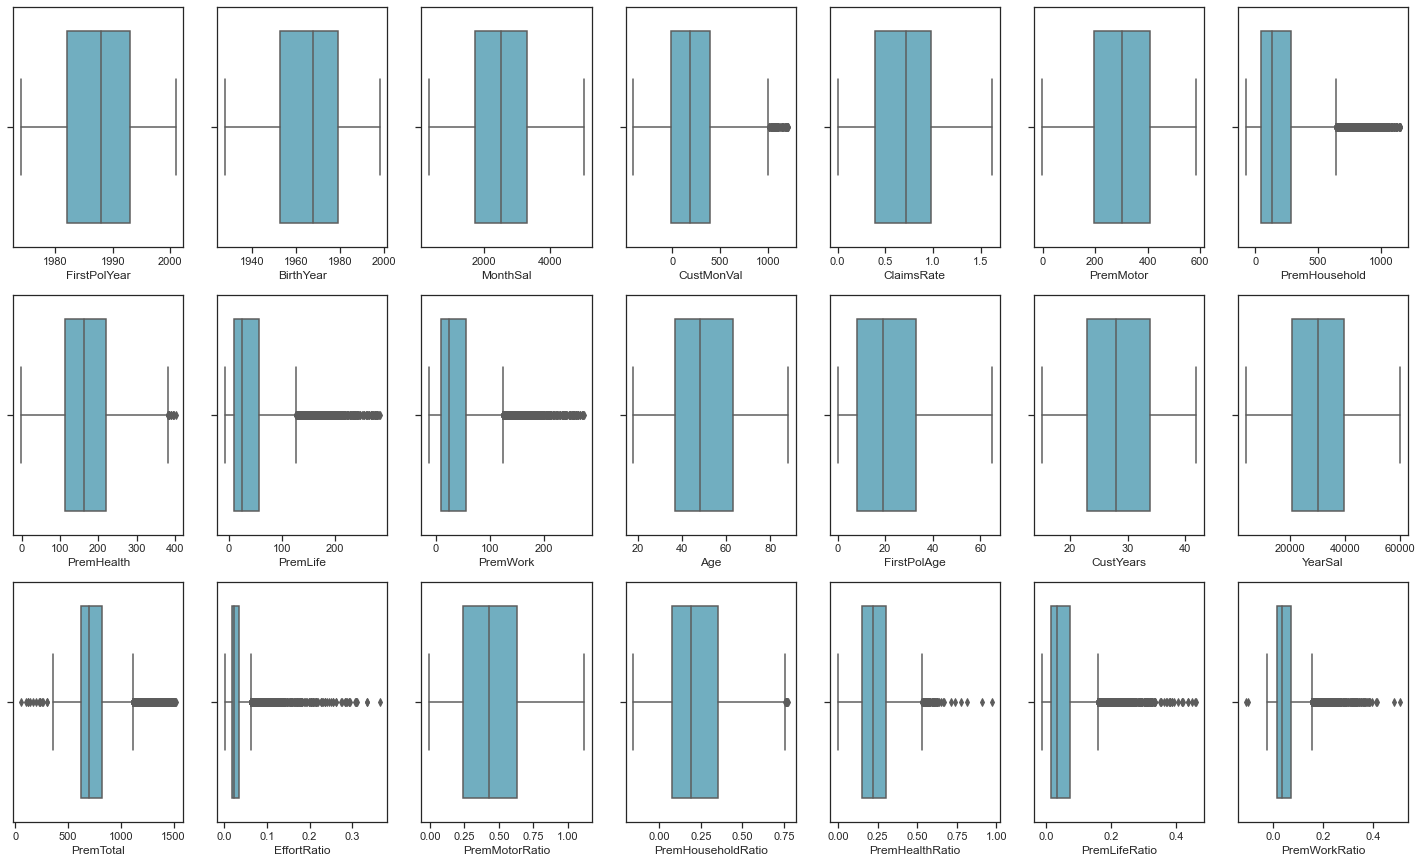

In [37]:
# plot metric features
plot_multiple(df, metric_features, "box", fig_dimensions = [25, 15], nr_rows = 3)

In [38]:
# conditions to remove outliers
filters = (
    (df.PremHouseholdRatio.ge(0.85)),
    (df.PremHealthRatio.ge(0.64)),
    (df.PremLifeRatio.ge(0.40)),
    (df.PremWorkRatio.ge(0.40)),
    (df.PremWorkRatio.le(-0.05)),
    (df.PremTotal.le(350)),
    (df.PremTotal.ge(1750)),
    (df.EffortRatio.ge(0.26))
)

# remove outliers from newly created features, store them in outliers2
df, df_outliers2 = remove_outliers(df, filters)

# merge the two outliers dataframes
df_outliers = pd.concat([df_outliers1, df_outliers2])

Number of outliers removed: 50 (0.49% of all observations)


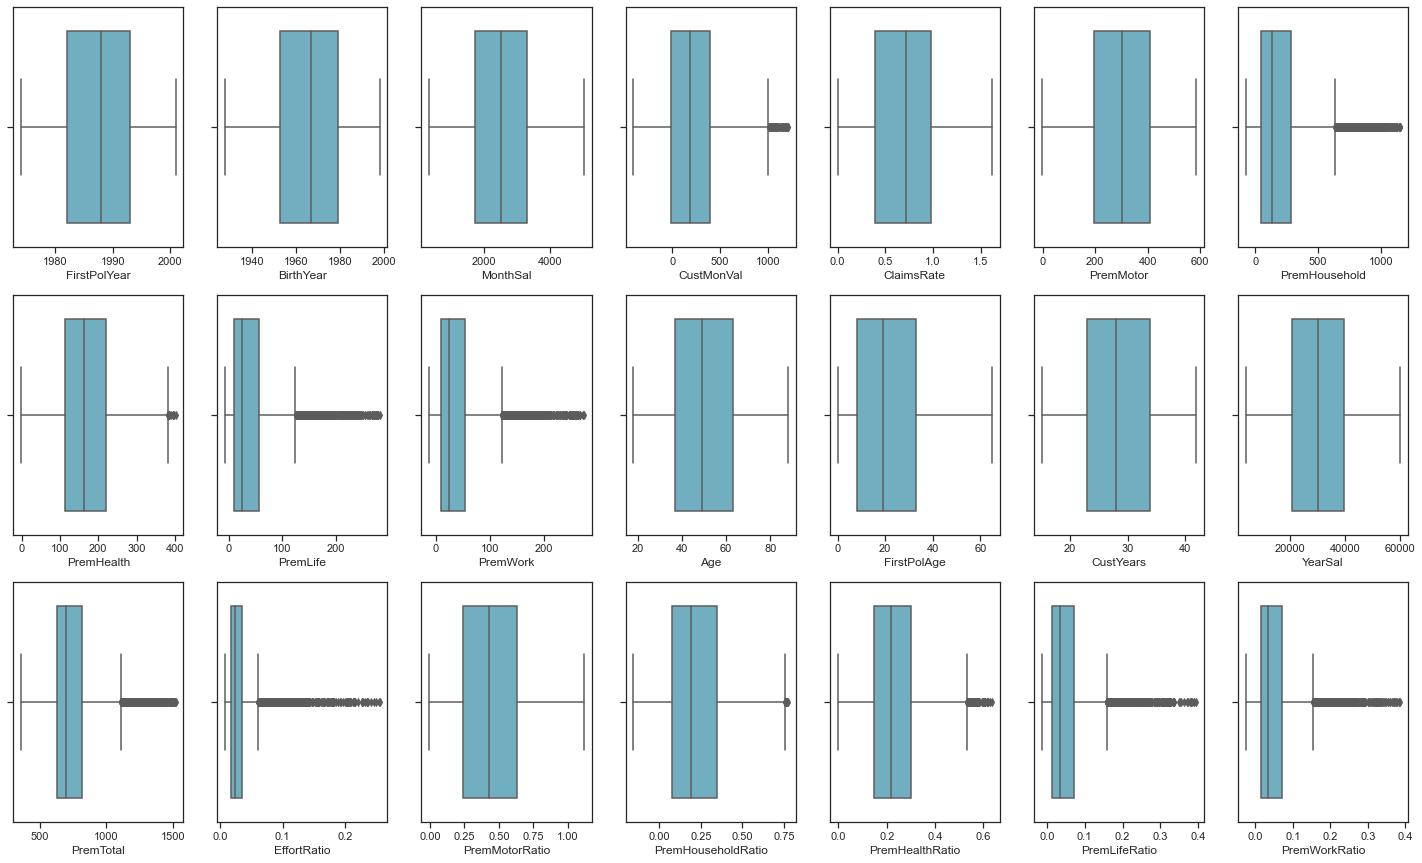

In [39]:
# boxplot of metric features after removing outliers
plot_multiple(df, metric_features, "box", [25, 15], 3)

<a class="anchor" id="preprocessing-feature-selection"></a>

<h3><right>Feature selection</right></h3>

* Remove redundant features
* Remove irrelevant features
* Prepare dataframe for cluster analysis

In [40]:
def corr_heatmap(df, corrlimit, method = "pearson"):

    '''
    Takes in a dataframe, df, and a coefficient, method,
    as arguments and creates a correlation heatmap showing
    the correlations between all pairs of features in the
    dataframe.
    '''

    sns.set(style = "ticks")
    plt.subplots(figsize = (20, 15))

    mask = np.triu(np.ones_like(df.corr(method = method), dtype = bool))
    correlationmatrix=df.corr(method = method)
    annot_labels = correlationmatrix
    annot_mask = abs(correlationmatrix) <corrlimit
    annot_labels=round(annot_labels,2).astype(str)
    annot_labels[annot_mask] ='' 
    corr_heatmap = sns.heatmap(correlationmatrix, mask = mask, vmin = -1, vmax = 1, annot = annot_labels, cmap = 'BrBG',fmt='')
    corr_heatmap.set_title('Triangle Correlation Heatmap', fontdict = {'fontsize': 14}, pad = 8)

    return

In [41]:
def restructure_df(df):
    
    # reorganise column order
    df = df.loc[:, [
        "Generation",
        "Age",
        "YearSal",
        "EducDeg",
        "Children",
        "FirstPolAge",
        "CustYears",
        "CustMonVal",
        "ClaimsRate",
        "PremMotor",
        "PremMotorRatio",
        "PremHousehold",
        "PremHouseholdRatio",
        "PremHealth",
        "PremHealthRatio",
        "PremLife",
        "PremLifeRatio",
        "PremWork",
        "PremWorkRatio",
        "PremTotal",
        "EffortRatio"
        ]
    ]
    
    # rename a few columns
    df = df.rename(columns = {
        "CustMonVal": "CMV",
        "PremMotor": "Motor",
        "PremMotorRatio": "MotorRatio",
        "PremHousehold": "House",
        "PremHouseholdRatio": "HouseRatio",
        "PremHealth": "Health",
        "PremHealthRatio": "HealthRatio",
        "PremLife": "Life",
        "PremLifeRatio": "LifeRatio",
        "PremWork": "Work",
        "PremWorkRatio": "WorkRatio"
        }
    )
    
    return df

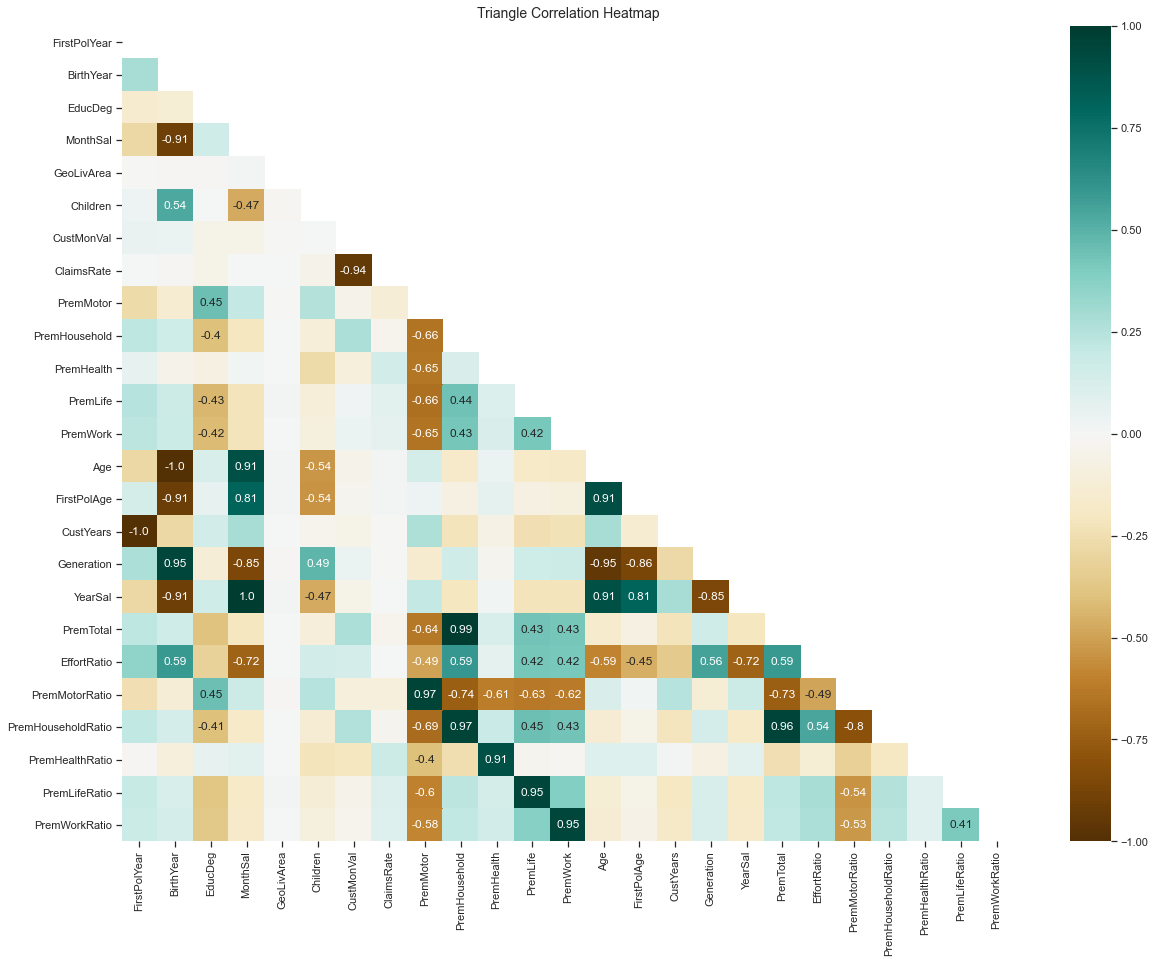

In [42]:
# correlation heatmap of features in the dataframe
corr_heatmap(df,0.4)

In [43]:
# remove redundant features from main dataframe (perfect correlation)
df.drop(columns = ["FirstPolYear", "BirthYear", "MonthSal"], inplace = True)

# TO BE DECIDED (based on future clustering) !!!!!!!!!!!!!!
# Age vs FirstPolAge vs Generation vs YearSal
# ClaimsRate vs CustMonVal
# PremTotal vs PremHousehold
# PremTotal vs PremHousehold_ratio
# Prem ratios vs Prem values

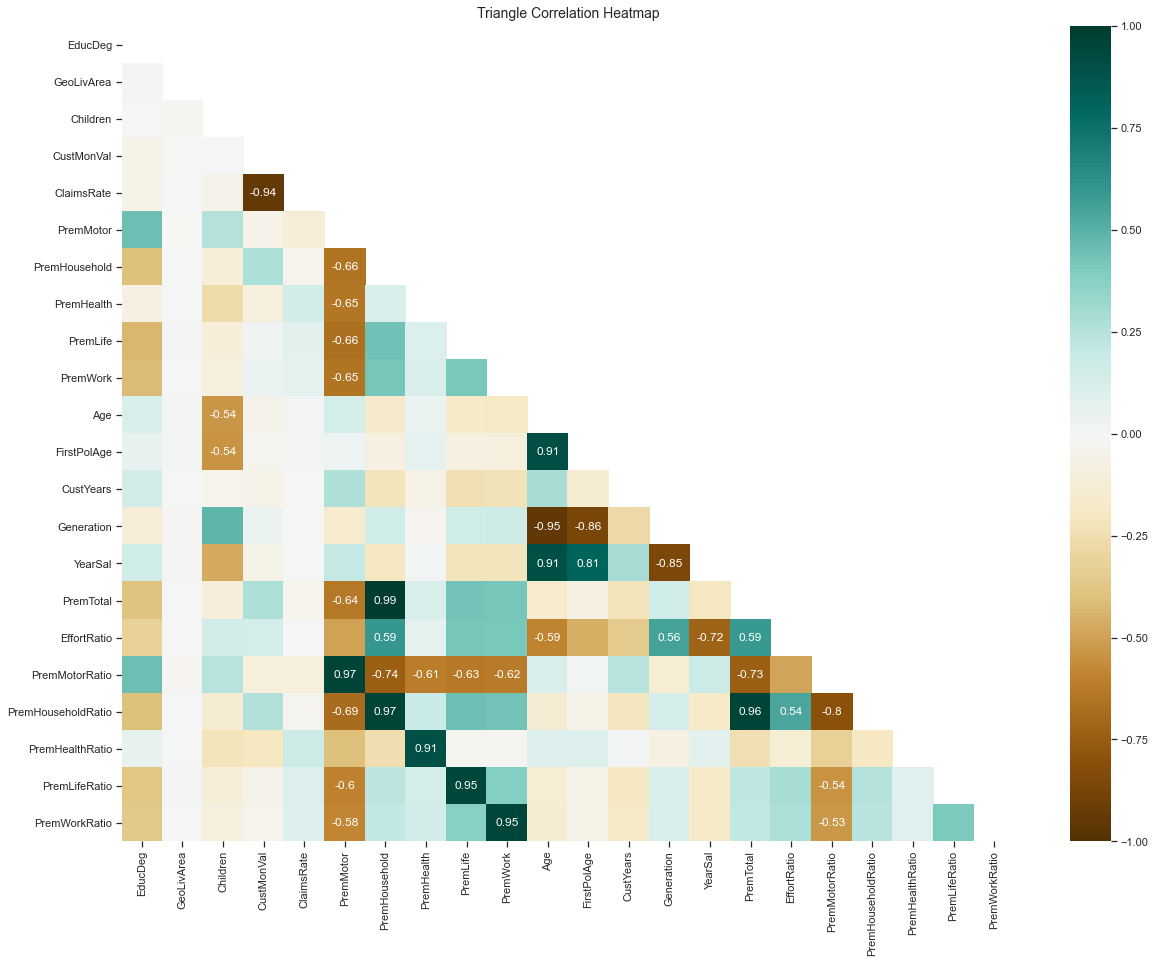

In [44]:
# correlation heatmap after updating features
corr_heatmap(df,0.5)

In [45]:
# updating metric and non-metric features
metric_features = df.columns.drop(["EducDeg", "GeoLivArea", "Children", "Generation"])
non_metric_features = ["EducDeg", "GeoLivArea", "Children", "Generation"]

print("Metric features:", metric_features)
print("Non-metric features:", non_metric_features)

Metric features: Index(['CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth',
       'PremLife', 'PremWork', 'Age', 'FirstPolAge', 'CustYears', 'YearSal',
       'PremTotal', 'EffortRatio', 'PremMotorRatio', 'PremHouseholdRatio',
       'PremHealthRatio', 'PremLifeRatio', 'PremWorkRatio'],
      dtype='object')
Non-metric features: ['EducDeg', 'GeoLivArea', 'Children', 'Generation']


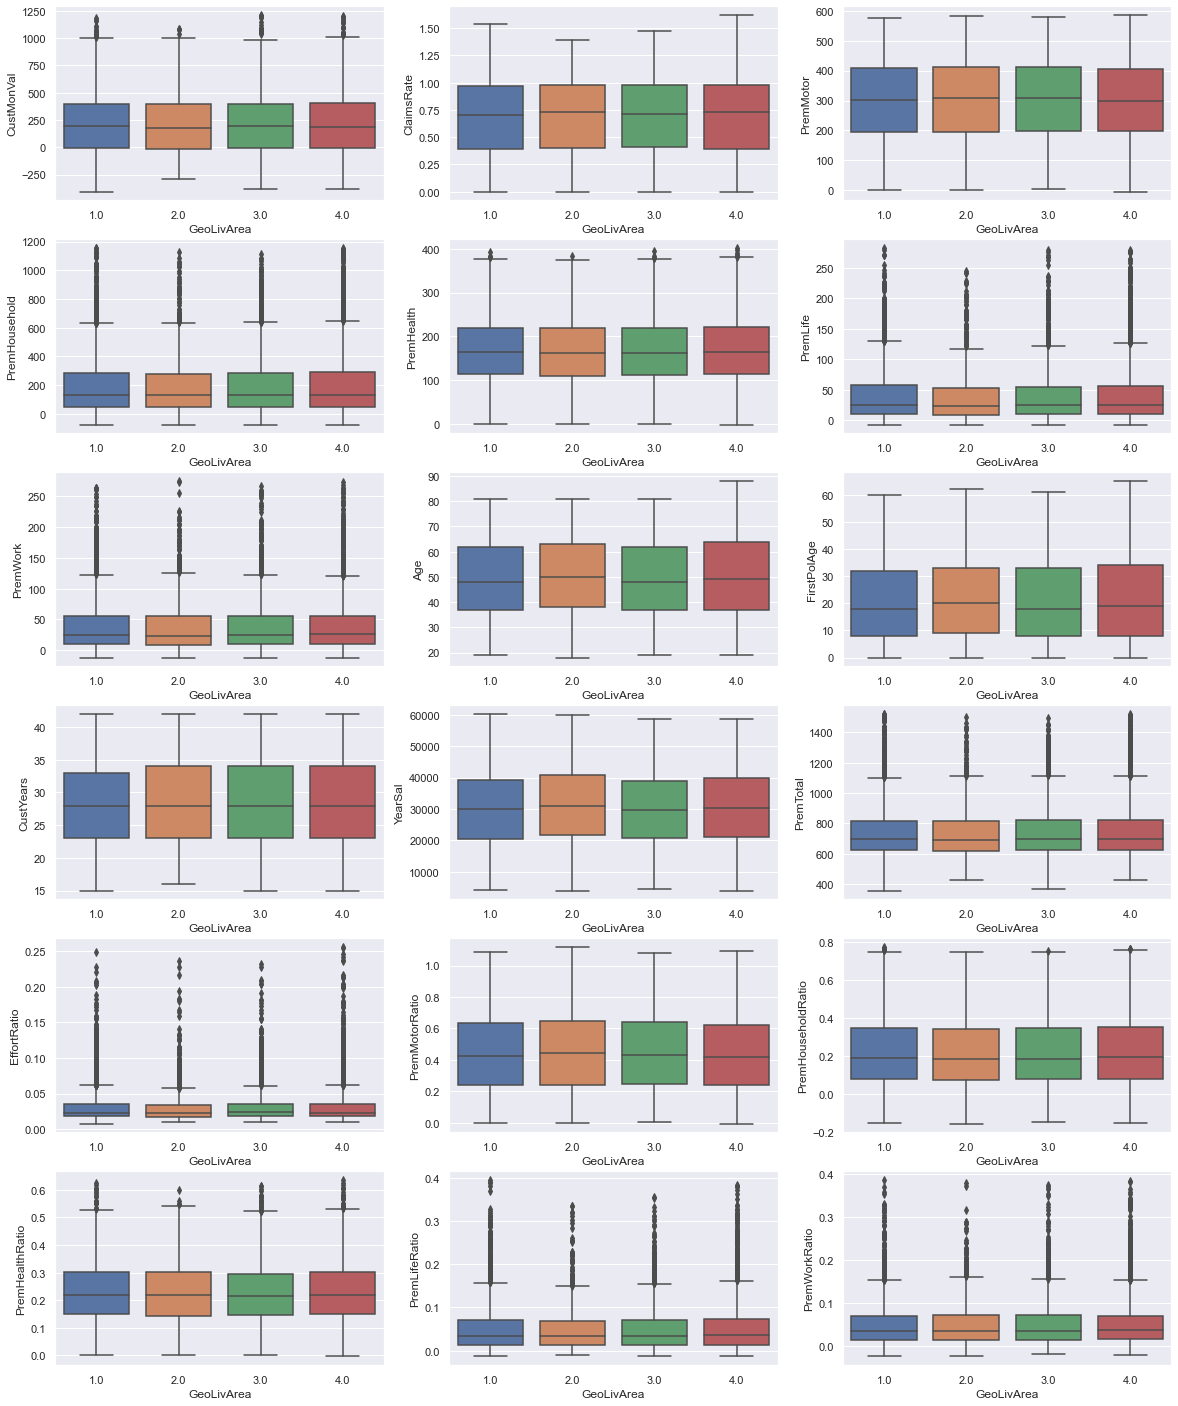

In [46]:
# Correlation heatmap hinted at GeoLivArea having no meaningful correlation with any feature
# visual representation of GeoLivArea and its relation with other features
sns.set()

fig, axes = plt.subplots(6, 3, figsize=(20, 25))

for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x = df["GeoLivArea"], y = df[feat], ax = ax)
    
plt.show()

# confirms that GeoLivArea appears to have no discriminative power

In [47]:
# remove GeoLivArea from the main dataframe
df.drop(columns = "GeoLivArea", inplace = True)

# remove GeoLivArea from df_outliers
df_outliers.drop(columns = "GeoLivArea", inplace = True)

In [48]:
# restructure and visualize the main dataframe before cluster analysis
df = restructure_df(df)
df.head()

,Generation,Age,YearSal,EducDeg,Children,FirstPolAge,CustYears,CMV,ClaimsRate,Motor,...,House,HouseRatio,Health,HealthRatio,Life,LifeRatio,Work,WorkRatio,PremTotal,EffortRatio
CustID,,,,,,,,,,,,,,,,,,,,,
1,4.0,34.0,26124.0,2.0,1.0,3.0,31.0,380.97,0.39,375.85,...,79.45,0.119373,146.36,0.219905,47.01,0.070632,16.89,0.025377,665.56,0.025477
2,4.0,35.0,8124.0,2.0,1.0,14.0,21.0,-131.13,1.12,77.46,...,416.20,0.456881,116.69,0.128096,194.48,0.213489,106.13,0.116503,910.96,0.112132
3,3.0,46.0,27324.0,1.0,0.0,21.0,25.0,504.67,0.28,206.15,...,224.50,0.303133,124.58,0.168215,86.35,0.116595,99.02,0.133702,740.60,0.027104
4,4.0,35.0,13188.0,3.0,1.0,9.0,26.0,-16.99,0.99,182.48,...,43.35,0.072168,311.17,0.518030,35.34,0.058833,28.34,0.047180,600.68,0.045547
5,3.0,43.0,21156.0,3.0,1.0,13.0,30.0,35.23,0.90,338.62,...,47.80,0.075965,182.59,0.290175,18.78,0.029846,41.45,0.065873,629.24,0.029743


In [49]:
# restructure and visualize the outliers dataframe before cluster analysis
df_outliers = restructure_df(df_outliers)
df_outliers.head()

,Generation,Age,YearSal,EducDeg,Children,FirstPolAge,CustYears,CMV,ClaimsRate,Motor,...,House,HouseRatio,Health,HealthRatio,Life,LifeRatio,Work,WorkRatio,PremTotal,EffortRatio
CustID,,,,,,,,,,,,,,,,,,,,,
9295,2.0,68.0,39216.0,3.0,0.0,51836.0,-51768.0,348.85,0.37,351.40,...,15.00,0.025253,187.37,0.315438,22.45,0.037795,17.78,0.029933,594.00,0.015147
5883,2.0,60.0,662580.0,2.0,1.0,39.0,21.0,122.25,0.79,281.83,...,147.25,0.207161,130.58,0.183708,84.46,0.118824,66.68,0.093810,710.80,0.001073
8262,4.0,35.0,413880.0,2.0,0.0,10.0,25.0,608.89,0.28,57.01,...,358.95,0.405062,195.26,0.220344,113.80,0.128419,161.14,0.181841,886.16,0.002141
52,3.0,50.0,38808.0,3.0,1.0,16.0,34.0,-14714.08,25.36,557.44,...,20.00,0.033167,29.56,0.049022,5.00,0.008292,-9.00,-0.014925,603.00,0.015538
113,3.0,37.0,28248.0,4.0,1.0,18.0,19.0,-8719.04,15.65,518.32,...,4.45,0.007499,55.90,0.094195,3.89,0.006555,10.89,0.018350,593.45,0.021009


In [50]:
# update metric and non-metric features
metric_features = df.columns.drop(["EducDeg", "Children", "Generation"])
non_metric_features = ["EducDeg", "Children", "Generation"]

# compute total number of observations removed
nr_rows_removed = initial_len - len(df)
pc_rows_removed = round((nr_rows_removed / initial_len) * 100, 2)

print(
    f"Total number of observations removed: {nr_rows_removed} ({pc_rows_removed}%)\n"
    f"Final number of observations: {df.shape[0]} ({100 - pc_rows_removed}%)\n"
    f"Current number of features: {df.shape[1]}\n"
    "Features:",
    list(df.columns)
)

Total number of observations removed: 242 (2.35%)
Final number of observations: 10051 (97.65%)
Current number of features: 21
Features: ['Generation', 'Age', 'YearSal', 'EducDeg', 'Children', 'FirstPolAge', 'CustYears', 'CMV', 'ClaimsRate', 'Motor', 'MotorRatio', 'House', 'HouseRatio', 'Health', 'HealthRatio', 'Life', 'LifeRatio', 'Work', 'WorkRatio', 'PremTotal', 'EffortRatio']


<a class="anchor" id="preprocessing-scaling"></a>

<h3><right>Feature skewness</right></h3>

In [51]:
def transform_skewed_features(df, features, transformation):

    # create dataframe with the transformed features
    df_transformed = df.copy()

    for feat in features:
        # ensure all values are non-negative and apply square root transformation
        if transformation.lower() == "sqrt":
            df_transformed[feat] = np.sqrt(df_transformed[feat] + abs(df_transformed[feat].min()))

        # ensure all values are positive and apply log10 transformation
        if transformation.lower() == "log10":
            df_transformed[feat] = np.log10(df_transformed[feat] + abs(df_transformed[feat].min()) + 1)

    return df_transformed

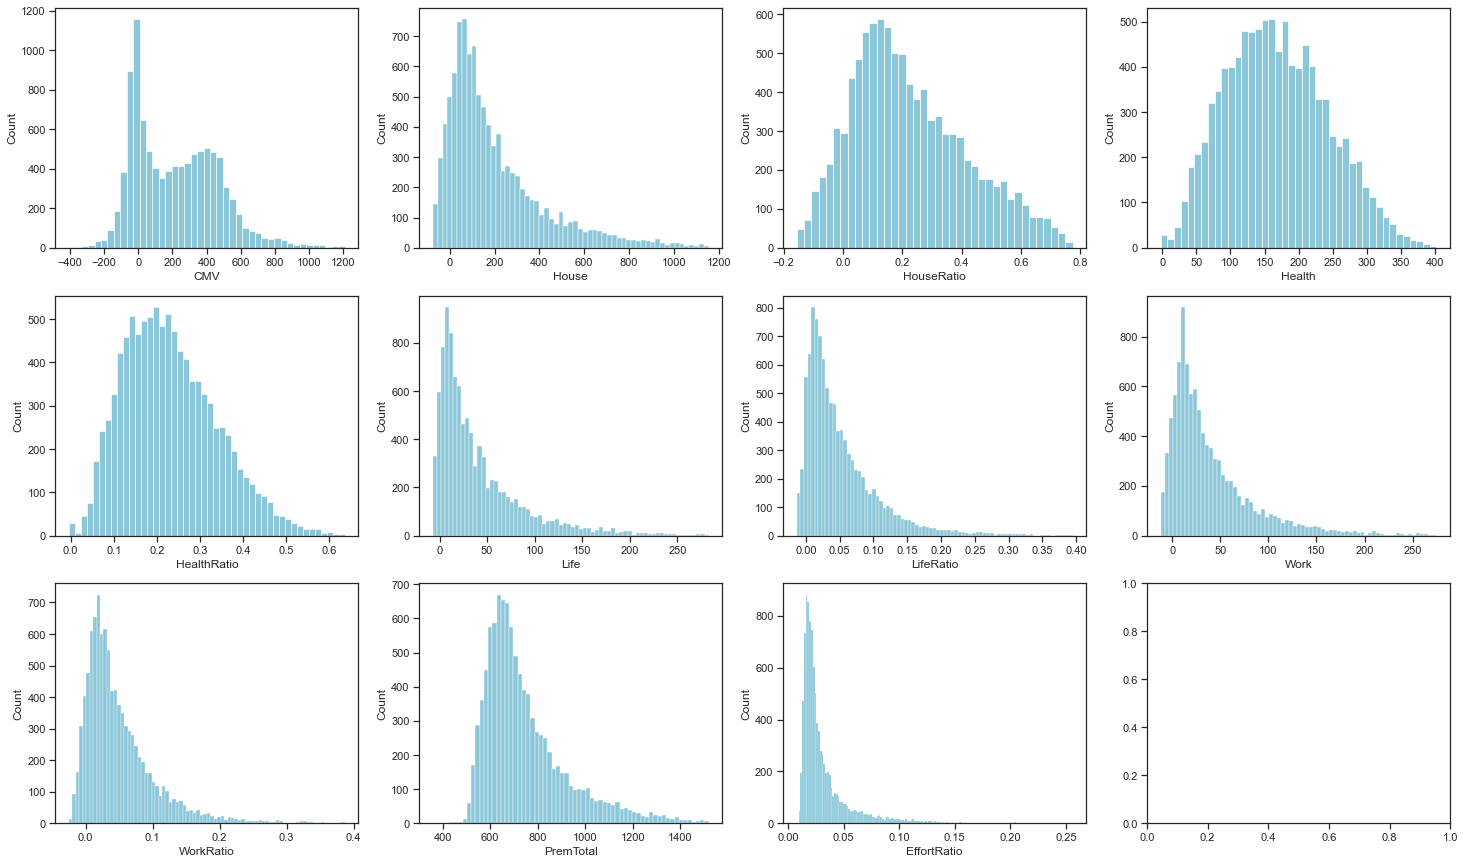

In [52]:
features = [
    "CMV",
    "House",
    "HouseRatio",
    "Health",
    "HealthRatio",
    "Life",
    "LifeRatio",
    "Work",
    "WorkRatio",
    "PremTotal",
    "EffortRatio"
]

# plot histogram of the potentially skewed metric features
plot_multiple(df, features, "histogram", [25, 15], nr_rows = 3)

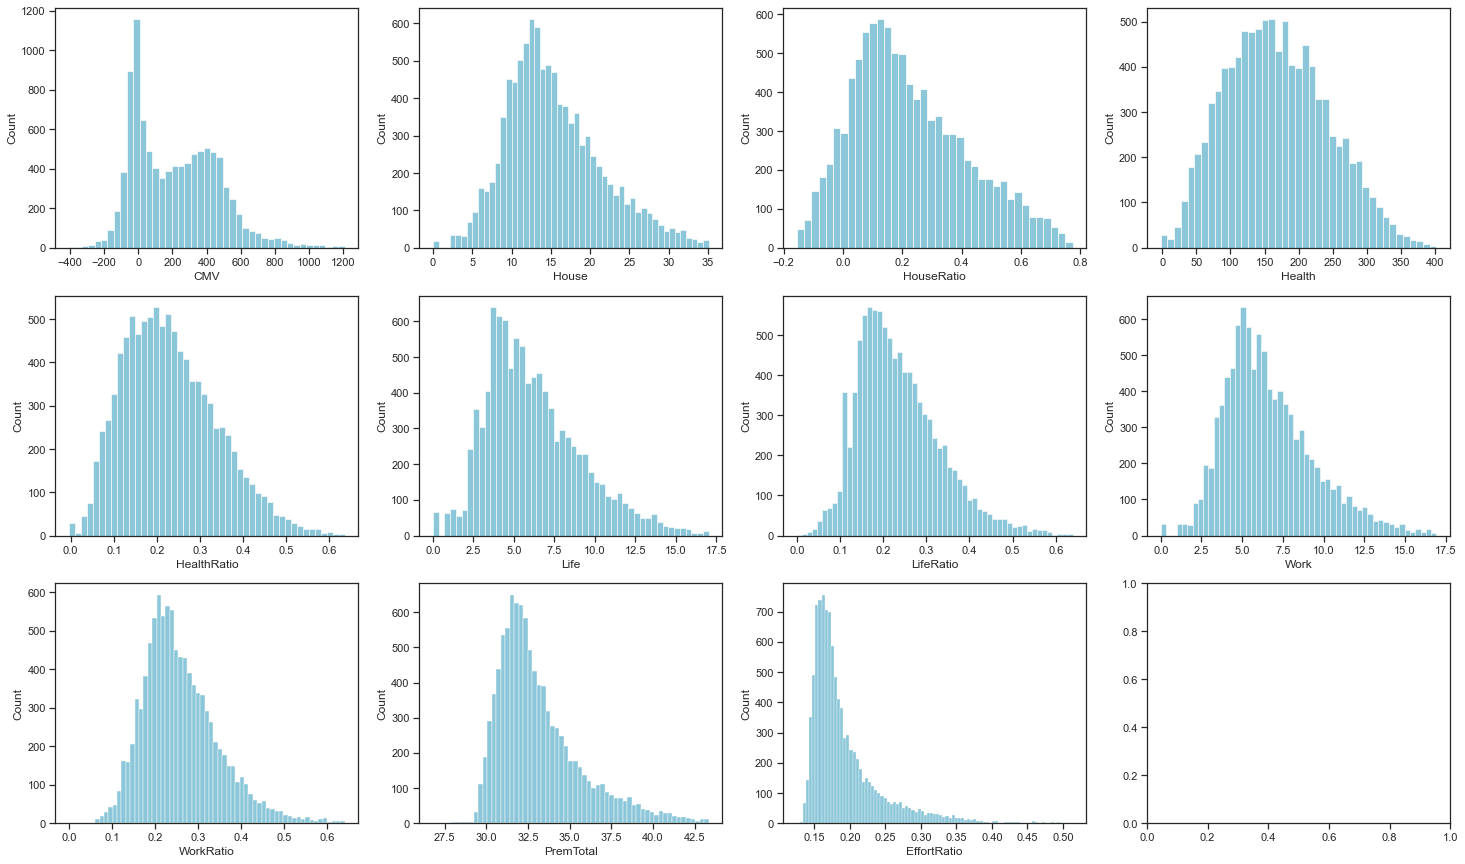

In [53]:
# list of skewed metric features
skewed_features = [
    "House",
    "Life",
    "LifeRatio",
    "Work",
    "WorkRatio",
    "PremTotal",
    "EffortRatio"
]

# apply transformation to the skewed features  (could maybe apply log10 to PremTotal alone???????????????????????)
# save transformed features (and the others) in a copy of the original dataframe to preserve original values
df_transformed = transform_skewed_features(df, skewed_features, transformation = "sqrt")

# plot histogram of transformed features
plot_multiple(df_transformed, features, "histogram", [25, 15], nr_rows = 3)

In [54]:
# list of features in the dataframe
features = list(df_transformed.columns)

In [55]:
# At this point there are 3 important dataframes
#  df             - original, not transformed values (no square root transformation of skewed features)
#  df_transformed - identical to df except that square root transformation was applied to skewed metric features
#  df_outliers    - all of the outliers removed from df

<a class="anchor" id="data-clustering"></a>

***

<h2><center>CLUSTERING</center></h2>

***

In [56]:
def data_scaler(df, scaler_name):

    '''
    Takes in a dataframe, df, and the name of the scaler,
    scaler_name, as arguments and applies the corresponding
    scaling method to the dataframe.

    Arguments:
     df (dataframe): dataframe without the target, y
     scaler_name (str): name of the scaler (minmax,
    standard, robust)

    Returns:
     df_scaled (dataframe): scaled version of the original df
    '''

    df_scaled = df.copy()
    features = list(df.columns)

    if scaler_name.lower() == "minmax":
        df_scaled[features] = MinMaxScaler().fit_transform(df)

    if scaler_name.lower() == "standard":
        df_scaled[features] = StandardScaler().fit_transform(df)

    if scaler_name.lower() == "robust":
        df_scaled[features] = RobustScaler().fit_transform(df)
    
    return df_scaled

In [57]:
def kmeans_clustering(df, k):

    '''
    Takes in a dataframe, df, and a number of clusters, k,
    and assigns rows of the dataframe to clusters based on
    the KMeans algorithm.

    Arguments:
     df (dataframe): dataframe
     k (int): number of clusters

    Returns:
     centroids (ndarray): center of each cluster
     labels (ndarray): label of each row indicating the
    cluster it was assigned to
    '''
    
    clusters = KMeans(
        n_clusters = k,
        random_state = 15
    ).fit(df)
    labels = clusters.labels_
    centroids = clusters.cluster_centers_

    return (centroids, labels)

In [58]:
def kprototypes_clustering(df, k, cat_index, init = "Huang"):

    clusters = KPrototypes(
        n_clusters = k,
        init = init,
        random_state = 15
    ).fit(df, categorical = cat_index)
    labels = clusters.labels_
    centroids = clusters.cluster_centroids_

    return (centroids, labels)

In [59]:
def hierarchical_clustering(df, n_clusters = None, threshold = 10000, affinity = "euclidean", linkage = "ward"):
    
    # determine clusters
    clusters = AgglomerativeClustering(
        n_clusters = n_clusters,
        affinity = affinity,
        linkage = linkage,
        distance_threshold = threshold
    ).fit(df)
    
    # retrieve cluster labels and distances
    labels = clusters.labels_
    distances = clusters.distances_
    
    counts = np.zeros(clusters.children_.shape[0])
    n_samples = len(labels)
    
    for i, merge in enumerate(clusters.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack([clusters.children_, distances, counts]).astype(float)
    
    return (distances, labels, linkage_matrix)

In [60]:
def db_scan(df,k):
    for eps in range(1,8):
        for min_samples in range(1,10):
            clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(df)
            print(set(clustering.labels_))
            if len(set(clustering.labels_))==k+1:
                return (None,clustering.labels_)
            if len(set(clustering.labels_))==2 or len(set(clustering.labels_))==1:
                return None
    return (None)


In [61]:
#takes in the results from one of the clustering algorithms and the data and presents the means
def summarise_clustering(labels):
    df_temp=df.copy()
    df_temp["Cluster"]=labels
    return df_temp.groupby("Cluster").mean()

In [62]:
def elbow_plot(df, nmax_clusters, algorithm, cat_index = None, init = "Huang"):
    
    # store inertia values in a list
    y_vals = []
    
    # determine inertia for each number of clusters
    for n in np.arange(2, nmax_clusters + 1):
        if algorithm.lower() == "kmeans":
            km_clusters = KMeans(n_clusters = n, random_state = 15).fit(df)
            inertia = km_clusters.inertia_
            y_vals.append(inertia)

        if algorithm.lower() == "kprototypes":
            if type(cat_index) is int:
                cat_index = [cat_index]
            kp_clusters = KPrototypes(
                n_clusters = n,
                init = init,
                random_state = 15
            ).fit(df, categorical = cat_index)
            cost = kp_clusters.cost_
            y_vals.append(cost)
    
    # plot elbow graph
    sns.set_style("ticks")
    plt.subplots(figsize = (8, 6))
    sns.lineplot(x = np.arange(2, nmax_clusters + 1),
        y = y_vals,
        color = "k",
        marker = 'o',
        mew = 0,
        linewidth = 3)
    plt.title("Elbow plot", fontsize = 22)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xlim([0, nmax_clusters+1])
    plt.xlabel("Number of clusters, k", fontsize = 18)

    if algorithm.lower() == "kmeans":
        plt.ylabel("Inertia", fontsize = 18)
    elif algorithm.lower() == "kprototypes":
        plt.ylabel("Cost", fontsize = 18)

    return

<a class="anchor" id="clustering-sociodemographic"></a>

<h3><right>Sociodemographic clustering</right></h3>

In [63]:
# sociodemographic features - Generation, Age, YearSal, EducDeg, Children
# Age redundant with YearSal and Generation - choose which of these to include in the clustering
# do not use a distance based method if including Children (binary)
df_sociodem = df[["Age", "Generation", "YearSal","EducDeg", "Children"]]

# data scaling
df_sociodem_minmax = data_scaler(df_sociodem, "minmax")
df_sociodem_standard = data_scaler(df_sociodem.drop(columns = "Children"), "standard")

,Generation,Age,YearSal,EducDeg,Children,FirstPolAge,CustYears,CMV,ClaimsRate,Motor,...,House,HouseRatio,Health,HealthRatio,Life,LifeRatio,Work,WorkRatio,PremTotal,EffortRatio
Cluster,,,,,,,,,,,,,,,,,,,,,
1,3.461272,35.836994,19725.906918,1.692871,0.870135,9.935645,25.901349,231.597954,0.699981,219.318551,...,311.332274,0.317330,175.682678,0.223922,66.233846,0.077391,64.290116,0.075073,836.857464,0.053424
3,3.334043,38.728723,23130.602073,3.124113,0.916667,10.241135,28.487589,210.504691,0.659957,357.957812,...,126.702730,0.152558,156.004578,0.226665,24.158096,0.033107,24.370752,0.033228,689.193968,0.034132
0,1.797820,63.784936,40119.636559,1.816650,0.496531,33.939544,29.845391,217.834945,0.696506,267.376938,...,246.592914,0.275082,173.767909,0.228292,49.497359,0.063109,47.855164,0.061348,785.090282,0.020024
2,1.737968,64.514515,40472.157366,3.129488,0.484339,34.682200,29.832315,204.108040,0.671524,342.586379,...,130.242303,0.164531,168.700206,0.245120,25.592299,0.036081,25.227670,0.035614,692.348858,0.017541


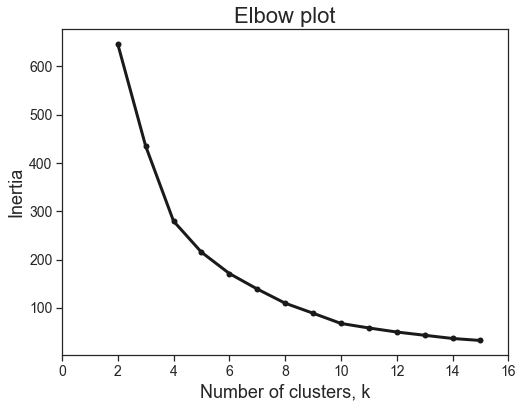

In [64]:
# Clustering solution 1: KMeans (Age, EducDeg)
km1_sociodem = df_sociodem_minmax[["Age", "EducDeg"]]

elbow_plot(km1_sociodem, 15, "kmeans")

km1_sociodem_centroids, km1_sociodem_clusters = kmeans_clustering(km1_sociodem, 4)

df["Cluster"] = km1_sociodem_clusters

df.groupby("Cluster").mean().sort_values("Age")

,Generation,Age,YearSal,EducDeg,Children,FirstPolAge,CustYears,CMV,ClaimsRate,Motor,...,House,HouseRatio,Health,HealthRatio,Life,LifeRatio,Work,WorkRatio,PremTotal,EffortRatio
Cluster,,,,,,,,,,,,,,,,,,,,,
3,3.474541,35.061352,18976.714713,1.642321,0.865192,9.481219,25.580134,234.267901,0.704132,202.565192,...,331.020952,0.334730,180.379833,0.227423,70.209428,0.081477,68.292713,0.079183,852.468118,0.055932
0,3.133996,40.980809,24691.108251,3.000000,0.912954,12.277587,28.703221,214.401343,0.655942,361.267087,...,130.221573,0.156264,151.271998,0.218853,24.721278,0.033782,24.638208,0.033498,692.120144,0.032468
2,1.932792,62.114569,39098.758041,1.860171,0.535408,32.276049,29.838521,216.184808,0.692332,281.169193,...,231.125643,0.260070,168.863378,0.224116,46.703072,0.059976,45.004614,0.058139,772.865900,0.020311
1,1.907540,62.909524,39339.584109,3.273413,0.471825,33.274603,29.634921,199.347206,0.676623,338.156671,...,126.305357,0.160705,174.673952,0.254884,24.995944,0.035415,24.951298,0.035394,689.083222,0.018822


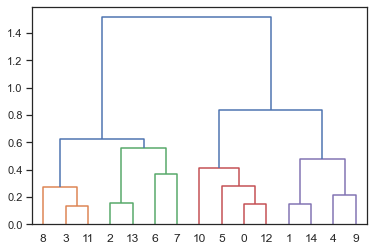

In [65]:
# Clustering solution 2: KMeans followed by Hierarchical clustering (Age, EducDeg)
km2_sociodem_centroids, km2_sociodem_clusters = kmeans_clustering(km1_sociodem, 15)

km2_sociodem_linkage = hierarchy.linkage(km2_sociodem_centroids, method = "ward")
hierarchy.dendrogram(km2_sociodem_linkage, color_threshold = 0.6)

# dendrogram suggests 4 clusters
df["Cluster"] = km2_sociodem_clusters

cluster0 = (
    (df.Cluster == 8)
    | (df.Cluster == 3)
    | (df.Cluster == 11)
)
cluster1 = (
    (df.Cluster == 2)
    | (df.Cluster == 13)
    | (df.Cluster == 6)
    | (df.Cluster == 7)
)

cluster2 = (
    (df.Cluster == 10)
    | (df.Cluster == 5)
    | (df.Cluster == 0)
    | (df.Cluster == 12)
)

cluster3 = (
    (df.Cluster == 1)
    | (df.Cluster == 14)
    | (df.Cluster == 4)
    | (df.Cluster == 9)
)

df.loc[cluster0, "Cluster"] = 0
df.loc[cluster1, "Cluster"] = 1
df.loc[cluster2, "Cluster"] = 2
df.loc[cluster3, "Cluster"] = 3

df.groupby("Cluster").mean().sort_values("Age")

In [ ]:
kp1_sociodem = df_sociodem_minmax[["Age", "EducDeg", "Children"]]

elbow_plot(kp1_sociodem, 15, "kprototypes", cat_index = 2)

In [ ]:
# Clustering solution 3: KPrototypes (Age, EducDeg, Children)
kp1_sociodem_centroids, kp1_sociodem_clusters = kprototypes_clustering(kp1_sociodem, k = 4, cat_index = 2)

df["Cluster"] = kp1_sociodem_clusters

df.groupby("Cluster").mean().sort_values("Age")

In [ ]:
# Clustering solution 4: KPrototypes followed by Hierarchical clustering (Age, EducDeg, Children)
kp2_sociodem_centroids, kp2_sociodem_clusters = kprototypes_clustering(kp1_sociodem, k = 15, cat_index = 2)

kp2_sociodem_linkage = hierarchy.linkage(kp2_sociodem_centroids, method = "ward")
hierarchy.dendrogram(kp2_sociodem_linkage, color_threshold = 1.0)

df["Cluster"] = kp2_sociodem_clusters

cluster0 = (
    (df.Cluster == 10)
    | (df.Cluster == 4)
    | (df.Cluster == 2)
    | (df.Cluster == 6)
)
cluster1 = (
    (df.Cluster == 3)
    | (df.Cluster == 12)
    | (df.Cluster == 9)
    | (df.Cluster == 11)
)

cluster2 = (
    (df.Cluster == 14)
    | (df.Cluster == 7)
    | (df.Cluster == 8)
)

cluster3 = (
    (df.Cluster == 1)
    | (df.Cluster == 13)
    | (df.Cluster == 0)
    | (df.Cluster == 5)
)

df.loc[cluster0, "Cluster"] = 0
df.loc[cluster1, "Cluster"] = 1
df.loc[cluster2, "Cluster"] = 2
df.loc[cluster3, "Cluster"] = 3

df.groupby("Cluster").mean().sort_values("Age")

In [ ]:
# strip plot for cluster visualization?
# sns.set_style("ticks")

# # test = df.copy()
# # test.EducDeg = test.EducDeg.replace(educ_mapper)

# x_vars = ["Age", "EducDeg"]

# g = sns.PairGrid(df.sort_values("Age", ascending = False),
#                  x_vars = x_vars, y_vars = ["Cluster"],
#                  hue = "Children",
#                  height = 8,
#                  aspect = 0.85)

# g.map(sns.stripplot, size = 12, orient = "h", jitter = True,
#       palette = ["gray", "palevioletred"], alpha = 0.1)

# # add better labels
# g.set(ylabel = "Clusters")

# titles = ["Age", "EducDeg"]

# for ax, title in zip(g.axes.flat, titles):

#     # set axis titles
#     ax.set(title = title)

#     # horizontal grid
#     ax.xaxis.grid(False)
#     ax.yaxis.grid(True, lw = 1.5)
    
# plt.legend(title = "Children")

<a class="anchor" id="clustering-value"></a>

<h3><right>Value clustering</right></h3>

In [ ]:
# potentially relevant features for customer segmentation based on value
df_value = df_transformed[[
    "FirstPolAge",
    "CustYears",
    "CMV",
    "ClaimsRate",
    "PremTotal",
    "EffortRatio"
]]

# data scaling
df_value_minmax = data_scaler(df_value, "minmax")
df_value_standard = data_scaler(df_value, "standard")
df_value_robust = data_scaler(df_value, "robust")

In [ ]:
# CMV and ClaimsRate largely redundant so use only one
# not sure if EffortRatio, FirstPolAge and CustYears are useful / helpful, need to test
# definitely include CMV or ClaimsRate + PremTotal
# try different scaling methods: standard/robust better to deal with outliers than minmax

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


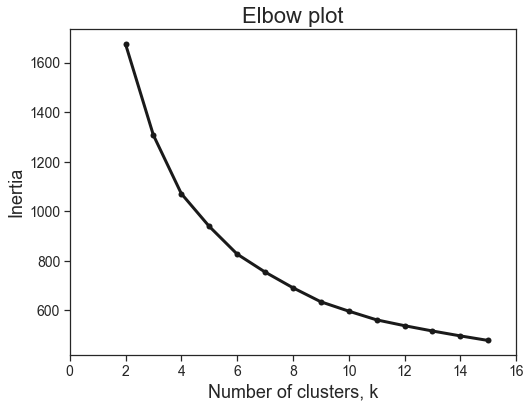

In [ ]:
# elbow plot
elbow_plot(df_value_minmax, 15, "kmeans")

In [ ]:
# Clustering solution 1: KMeans (all features in df_values)
km1_value = df_value_minmax[["CMV", "PremTotal", "EffortRatio"]]

km1_value_centroids, km1_value_clusters = kmeans_clustering(km1_value, 4)

df["Cluster"] = km1_value_clusters

print(df.groupby("Cluster").size())
df.groupby("Cluster").mean().sort_values("CMV")

<a class="anchor" id="clustering-product"></a>

<h3><right>Product clustering</right></h3>

In [67]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    hierarchy.dendrogram(linkage_matrix, **kwargs)

    return

In [68]:
# potentially relevant features to perform customer segmentation based on product
df_product = df_transformed[[
    "Motor", "MotorRatio",
    "House", "HouseRatio",
    "Health", "HealthRatio",
    "Life", "LifeRatio",
    "Work", "WorkRatio"
]]

# data scaling
df_product_minmax = data_scaler(df_product, "minmax")
df_product_standard = data_scaler(df_product, "standard")
df_product_robust = data_scaler(df_product, "robust")
scaled_data_sets=[(df_product_minmax,"minmax"),(df_product_robust,"robust"),(df_product_standard,"standard")]

In [69]:
# try clustering approaches using the values or using the ratios, choose one of the two
# possible good approaches: Agglomerative Clustering, KMeans, DBScan, Self Organizing Maps, others?
# try different scaling methods: standard/robust better to deal with outliers than minmax

In [70]:
#create sets of parameter combinations to try
df_product_values=["Motor","House","Health","Life","Work"]
df_product_ratios=["MotorRatio","HouseRatio","HealthRatio","LifeRatio","WorkRatio"]
df_product_all=["Motor", "MotorRatio","House", "HouseRatio","Health", "HealthRatio","Life", "LifeRatio","Work", "WorkRatio"]
df_product_object=["Motor","MotorRatio","House","HouseRatio"]
df_product_nonobject=["Health", "HealthRatio","Life", "LifeRatio","Work", "WorkRatio"]
combinations=[df_product_values,df_product_ratios,df_product_all,df_product_object,df_product_nonobject]

In [71]:
df.head()

,Generation,Age,YearSal,EducDeg,Children,FirstPolAge,CustYears,CMV,ClaimsRate,Motor,...,HouseRatio,Health,HealthRatio,Life,LifeRatio,Work,WorkRatio,PremTotal,EffortRatio,Cluster
CustID,,,,,,,,,,,,,,,,,,,,,
1,4.0,34.0,26124.0,2.0,1.0,3.0,31.0,380.97,0.39,375.85,...,0.119373,146.36,0.219905,47.01,0.070632,16.89,0.025377,665.56,0.025477,3
2,4.0,35.0,8124.0,2.0,1.0,14.0,21.0,-131.13,1.12,77.46,...,0.456881,116.69,0.128096,194.48,0.213489,106.13,0.116503,910.96,0.112132,3
3,3.0,46.0,27324.0,1.0,0.0,21.0,25.0,504.67,0.28,206.15,...,0.303133,124.58,0.168215,86.35,0.116595,99.02,0.133702,740.60,0.027104,3
4,4.0,35.0,13188.0,3.0,1.0,9.0,26.0,-16.99,0.99,182.48,...,0.072168,311.17,0.518030,35.34,0.058833,28.34,0.047180,600.68,0.045547,0
5,3.0,43.0,21156.0,3.0,1.0,13.0,30.0,35.23,0.90,338.62,...,0.075965,182.59,0.290175,18.78,0.029846,41.45,0.065873,629.24,0.029743,0


In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
for combination in combinations:
    for scaled_data,scaler_name in scaled_data_sets:
        for algorithm in [kmeans_clustering,hierarchical_clustering]:
            print(combination,scaler_name,algorithm.__name__)
            data=scaled_data[combination]
            if algorithm.__name__=="hierarchical_clustering":
                labels=algorithm(data)[1]
            elif algorithm.__name__=="kmeans_clustering":
                labels=algorithm(data,k=4)[1]
            elif algorithm.__name__=="db_scan":
                labels=algorithm(data,k=4)
                if labels is None:
                    continue
                labels=labels[1]
            results=summarise_clustering(labels)
            if not results.shape[0]==1:
                print(metrics.silhouette_score(X=data,labels=labels))
                display(results) #[sum([combination+["YearSal","Age"]],[])]

In [73]:
from sklearn.manifold import MDS


embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(df[:500])


<AxesSubplot:>

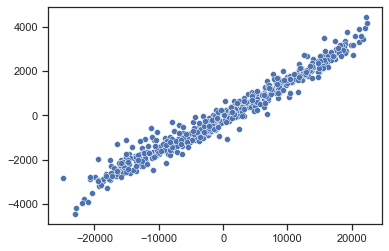

In [75]:
sns.scatterplot(x=X_transformed[:,0],y=X_transformed[:,1])

In [108]:
df_product_standard[df_product_ratios][:100].reset_index().columns.get_loc(11)

KeyError: 11

In [137]:
som_test=df_product_standard[df_product_ratios]

In [142]:
som_test.shape

(10051, 5)

In [159]:
from sklearn_som.som import SOM
som = SOM(m=3, n=2, dim=5)
som.fit(X=som_test.to_numpy(),shuffle=True)

In [160]:
predictions=som.predict(X=som_test.to_numpy())

In [162]:
predictions

array([2, 1, 0, ..., 5, 0, 5], dtype=int64)

In [161]:
metrics.silhouette_score(som_test,predictions)

0.1233624024984546

In [163]:
df["Cluster"]=predictions
df.groupby("Cluster").size()

Cluster
0    1921
1    2055
2    1708
3    1014
4    2426
5     927
dtype: int64

In [164]:
df.groupby("Cluster").mean()

,Generation,Age,YearSal,EducDeg,Children,FirstPolAge,CustYears,CMV,ClaimsRate,Motor,MotorRatio,House,HouseRatio,Health,HealthRatio,Life,LifeRatio,Work,WorkRatio,PremTotal,EffortRatio
Cluster,,,,,,,,,,,,,,,,,,,,,
0,2.667881,49.754815,29747.838463,2.239979,0.580427,22.051536,27.703280,143.871556,0.767897,182.008423,0.260387,160.341072,0.210413,233.049995,0.328157,66.412296,0.095162,74.824951,0.105881,716.636736,0.032669
1,2.901217,45.238443,26071.119168,1.928954,0.634063,19.352798,25.885645,323.958146,0.660783,154.888589,0.161836,539.697105,0.512210,168.072764,0.169244,83.200370,0.083964,73.695869,0.072745,1019.554696,0.055769
2,2.521663,51.899297,32074.380715,2.748244,0.652810,22.759953,29.139344,163.115978,0.712869,306.958642,0.475410,79.565779,0.115393,212.974643,0.328946,25.130826,0.039346,26.447775,0.040905,651.077664,0.024103
3,2.461538,52.737673,32188.542139,2.529586,0.683432,23.175542,29.562130,249.880888,0.659369,305.487890,0.382230,267.229241,0.326771,176.759753,0.220065,31.566765,0.040138,24.606657,0.030795,805.650306,0.029408
4,2.627782,49.756389,30923.026430,2.892828,0.884584,19.879225,29.877164,198.777585,0.631443,470.090173,0.782865,23.337881,0.033283,93.820054,0.156426,7.778215,0.013038,8.726451,0.014389,603.752774,0.020982
5,2.477886,52.271845,32547.278504,2.716289,0.799353,22.889968,29.381877,228.952222,0.636494,401.949730,0.577790,132.932632,0.187239,134.270917,0.194209,15.676472,0.022785,12.619277,0.017978,697.449029,0.023695
